In [1]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

In [2]:
# global variables
ppg_excel_file_path="Data File/PPG-BP dataset.xlsx"

In [3]:
# to get df for the patients data
def get_df():
    df = pd.read_excel(ppg_excel_file_path)
    df.columns = df.iloc[0]  # Assign first row as column names
    df = df[1:].reset_index(drop=True)  # Remove the first row and reset index
    return df

In [4]:
#helper function used to create a list of numbers from a txt file
def load_ppg_signal(file_path):
    with open(file_path, 'r') as f:
        content=f.read()
        numbers=[int(float(num)) for num in re.split(r'\s+',content.strip())]
    return numbers

In [5]:
#used to load the signal data for all the patients for all 3 segments
def load_ppg_signals():
    ppg_signal_data=[]
    for i in range(3):
        ppg_signal_data_i=[]
        for j in range(219):
            subject_ID=df["subject_ID"][j]
            ppg_file_path=f"Data File/0_subject/{subject_ID}_{i+1}.txt"
            ppg_signal=load_ppg_signal(ppg_file_path)
            ppg_signal_data_i.append(ppg_signal[:2100])
        ppg_signal_data.append(ppg_signal_data_i)
    return np.array(ppg_signal_data)

In [6]:
def apply_bandpass_filter(signal, lowcut=0.5, highcut=5.0, fs=1000, order=2):
    # Normalize cutoff frequencies to Nyquist frequency
    nyquist = fs / 2
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Design Butterworth bandpass filter
    b, a = butter(order, [low, high], btype='band')
    
    # Apply filter (zero-phase filtering with filtfilt)
    filtered_signal = filtfilt(b, a, signal)
    
    return filtered_signal

In [7]:
# since the peaks are not accurate as the signal is having noise 
# we will remove noise by using bandpass filters both low and high pass filter
# human heart rate BPM lies between [40-180] bpm 
# so in seconds it will be BPS [0.67 -3]
# so we will use a bandpass filter with frequency range of [0.5 -5]
#why noise
# Motion Artifacts:
# Cause: Physical movement of the subject (e.g., finger twitching, walking) alters 
# the sensor’s contact with the skin or the blood flow dynamics.
# Effects:Introduces low-frequency baseline wander or high-frequency spikes.

# Ambient Light Interference:
# Cause: External light sources (e.g., sunlight, fluorescent lights) penetrate the sensor, adding unwanted signals.
# Effects:Introduces low-frequency baseline wander
def remove_noise_from_ppg(ppg_signal_data_array, lowcut=0.5, highcut=4.0, fs=1000, order=4):
    # Get array dimensions
    num_segments, num_patients, num_samples = ppg_signal_data_array.shape
    # Initialize output array with same shape as input
    filtered_ppg_array = np.zeros_like(ppg_signal_data_array)
    # Apply filter to each segment of each patient
    for segment_idx in range(num_segments):
        for patient_idx in range(num_patients):
            # Extract raw signal
            raw_signal = ppg_signal_data_array[segment_idx, patient_idx, :]
            # Apply bandpass filter
            filtered_signal = apply_bandpass_filter(raw_signal)
            # Store filtered signal
            filtered_ppg_array[segment_idx, patient_idx, :] = filtered_signal
    
    return filtered_ppg_array

In [8]:
def plot_ppg_signal(ppg_signal_data_array, i, j,flag):
    # Sampling rate and time axis
    sampling_rate = 1000  # Hz
    time = np.arange(0, 2.1, 1/sampling_rate)  # 0 to 2.1 seconds
    # Extract the signal for the ith patient and jth segment
    signal = ppg_signal_data_array[j, i, :]
    # Ensure time and signal lengths match
    if len(time) != len(signal):
        time = time[:len(signal)]
    # Create a single plot
    ylabel="Raw ADC Value (12-bit)"
    if flag:
        ylabel="Filtered ADC Value"
    plt.figure(figsize=(10, 4))
    plt.plot(time, signal, label=f'Segment {j}', color='blue')
    plt.title(f'Patient {i} - Segment {j}')
    plt.xlabel('Time (seconds)')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    # Adjust layout and show
    plt.tight_layout()
    plt.show()

In [9]:
#plot with peaks and give heart rate estimated how to calculate we will tell
#peak must be local maxima 
#min distance between peaks be 300 and why??
# max BPM is 200
# max IBI=60/200 which is 0.3
#so min distance is 0.3*1000=300
def plot_ppg_signal_with_peaks(ppg_signal_data_array, i, j,flag):
    # Check array bounds
    num_segments, num_patients, num_samples = ppg_signal_data_array.shape
    if j >= num_segments or i >= num_patients:
        raise ValueError(f"Invalid indices: j={j} (max {num_segments-1}), i={i} (max {num_patients-1})")
    
    # Sampling rate and time axis
    sampling_rate = 1000  # Hz
    time = np.arange(0, 2.1, 1/sampling_rate)  # 0 to 2.1 seconds, 2100 points
    
    # Extract the signal
    signal = ppg_signal_data_array[j, i, :]
    
    # Ensure time and signal lengths match
    if len(time) != len(signal):
        time = time[:len(signal)]
    
    # Detect peaks (value > mean, min distance 0.3s = 300 samples at 1000 Hz)
    peaks, _ = find_peaks(signal, height=np.mean(signal), distance=300)
    
    # Calculate heart rate
    if len(peaks) >= 2:
        peak_times = peaks / sampling_rate  # Convert to seconds
        inter_beat_intervals = np.diff(peak_times)  # Time between consecutive peaks
        average_interval = np.mean(inter_beat_intervals)  # Average IBI in seconds
        heart_rate = 60 / average_interval  # BPM
        hr_text = f"{heart_rate:.2f} BPM"
    else:
        hr_text = "Insufficient peaks to calculate"
    
    # Create a single plot
    ylabel="Raw ADC Value (12-bit)"
    if flag:
        ylabel="Filtered ADC Value"
    plt.figure(figsize=(10, 4))
    plt.plot(time, signal, label=f'Segment {j}', color='blue')  # Continuous signal
    plt.scatter(time[peaks], signal[peaks], s=50, color='red', marker='x', label='Peaks')  # Mark peaks
    plt.title(f'Patient {i} - Segment {j} - Heart Rate: {hr_text}')
    plt.xlabel('Time (seconds)')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    # Adjust layout and show
    plt.tight_layout()
    plt.show()
    
    # Print result in one line
    print(f"Patient {i}, Segment {j} - Heart Rate: {hr_text}")

In [10]:
def plot_ppg_signal_all_segments(ppg_signal_data_array, i,flag,img_path):
    # Check array bounds
    num_segments, num_patients, num_samples = ppg_signal_data_array.shape
    # Sampling rate and time axis
    sampling_rate = 1000  # Hz
    time = np.arange(0, 2.1, 1/sampling_rate)  # 0 to 2.1 seconds
    
    # Create a figure with 1 row and 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
    
    # Plot each segment
    for j in range(3):  # Segments 0, 1, 2
        # Extract the signal for the ith patient and jth segment
        signal = ppg_signal_data_array[j, i, :]
        
        # Ensure time and signal lengths match
        if len(time) != len(signal):
            time = time[:len(signal)]
        
        # Plot on the respective subplot
        ax = axes[j]
        ax.plot(time, signal, label=f'Segment {j}', color='blue')
        ax.set_title(f'Segment {j}')
        ax.set_xlabel('Time (seconds)')
        ax.grid(True)
        ax.legend()
    
    # Set y-label on the first subplot
    if not flag:
        axes[0].set_ylabel(f'Patient {i}\nRaw ADC Value (12-bit)')
    else :
        axes[0].set_ylabel(f'Patient {i}\nFiltered ADC Value')
    # Adjust layout and add overall title
    plt.suptitle(f'Patient {i} - Segments 0, 1, 2', y=1.05)
    plt.tight_layout()
    plt.savefig(img_path, dpi=300, bbox_inches="tight")
    plt.show()


In [11]:
def plot_ppg_signal_with_peaks_all_segments(ppg_signal_data_array, i,flag,img_path):
    # Check array bounds
    num_segments, num_patients, num_samples = ppg_signal_data_array.shape    
    # Sampling rate and time axis
    sampling_rate = 1000  # Hz
    time = np.arange(0, 2.1, 1/sampling_rate)  # 0 to 2.1 seconds, 2100 points
    
    # Create a figure with 1 row and 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
    
    # Plot each segment
    heart_rates = {}
    for s_idx in range(3):  # Segments 0, 1, 2
        # Extract the signal
        signal = ppg_signal_data_array[s_idx, i, :]
        
        # Ensure time and signal lengths match
        if len(time) != len(signal):
            time = time[:len(signal)]
        
        # Detect peaks (value > mean, min distance 0.3s = 300 samples at 1000 Hz)
        peaks, _ = find_peaks(signal, height=np.mean(signal), distance=300)
        
        # Calculate heart rate
        if len(peaks) >= 2:
            peak_times = peaks / sampling_rate  # Convert to seconds
            inter_beat_intervals = np.diff(peak_times)
            average_interval = np.mean(inter_beat_intervals)
            heart_rate = 60 / average_interval  # BPM
            heart_rates[s_idx] = heart_rate
        else:
            heart_rates[s_idx] = None
        
        # Plot signal with peaks
        ax = axes[s_idx]
        ax.plot(time, signal, label=f'Segment {s_idx}', color='blue')
        ax.scatter(time[peaks], signal[peaks], s=50, color='red', marker='x', label='Peaks')
        hr_text = f"{heart_rates[s_idx]:.2f} BPM" if heart_rates[s_idx] is not None else "N/A"
        ax.set_title(f'Segment {s_idx} - HR: {hr_text}')
        ax.set_xlabel('Time (seconds)')
        ax.grid(True)
        ax.legend()
    
    # Set y-label on the first subplot
    if not flag:
        axes[0].set_ylabel(f'Patient {i}\nRaw ADC Value (12-bit)')
    else:
        axes[0].set_ylabel(f'Patient {i}\nFiltered ADC Value')
    # Adjust layout and add title
    plt.suptitle(f'PPG Signals for Patient {i} - Segments 0, 1, 2', y=1.05)
    plt.tight_layout()
    plt.savefig(img_path, dpi=300, bbox_inches="tight")
    plt.show()
    
    # Print heart rates in one line
    hr_output = f"Patient {i} - "
    for s_idx in range(3):
        hr = heart_rates[s_idx]
        hr_text = f"{hr:.2f} BPM" if hr is not None else "N/A"
        hr_output += f"Segment {s_idx}: {hr_text}, "
    print(hr_output.rstrip(", "))

In [12]:
#combine all the signals
def combine_all_segments(ppg_signal_data_array):
    num_segments, num_patients, num_samples = ppg_signal_data_array.shape
    combined_samples = num_samples * num_segments  # 2100 * 3 = 6300
    combined_signals = np.zeros((num_patients, combined_samples), dtype=ppg_signal_data_array.dtype)
    for patient_idx in range(num_patients):
        combined_signal = np.concatenate([
            ppg_signal_data_array[0, patient_idx, :],  # Segment 0
            ppg_signal_data_array[1, patient_idx, :],  # Segment 1
            ppg_signal_data_array[2, patient_idx, :]   # Segment 2
        ])
        combined_signals[patient_idx, :] = combined_signal
    
    return combined_signals

In [13]:
def remove_noise_from_combined_ppg(ppg_signal_data_array, lowcut=0.5, highcut=4.0, fs=1000, order=4):
    # Get array dimensions
    num_patients, num_samples = ppg_signal_data_array.shape
    # Initialize output array with same shape as input
    filtered_ppg_array = np.zeros_like(ppg_signal_data_array)
    # Apply filter to each segment of each patient
    for patient_idx in range(num_patients):
        # Extract raw signal
        raw_signal = ppg_signal_data_array[patient_idx, :]
        # Apply bandpass filter
        filtered_signal = apply_bandpass_filter(raw_signal)
        # Store filtered signal
        filtered_ppg_array[patient_idx, :] = filtered_signal
    return filtered_ppg_array

In [14]:
def plot_combined_ppg_signal(ppg_signal_data_array, i,flag):
    # Sampling rate and time axis
    sampling_rate = 1000  # Hz
    time = np.arange(0, 6.3, 1/sampling_rate)  # 0 to 6.3 seconds
    # Extract the signal for the ith patient
    signal = ppg_signal_data_array[i, :]
    # Ensure time and signal lengths match
    if len(time) != len(signal):
        time = time[:len(signal)]
    # Create a single plot
    plt.figure(figsize=(10, 4))
    plt.plot(time, signal, color='blue',label=f'combined all segments')
    plt.title(f'Patient {i}')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Raw ADC Value (12-bit)')
    if not flag:
        plt.ylabel('Raw ADC Value (12-bit)')
    else:
        plt.ylabel('Filtered ADC Value')
    plt.grid(True)
    plt.legend()
    # Adjust layout and show
    plt.tight_layout()
    plt.show()

In [15]:
def plot_combined_ppg_signal_with_peaks(ppg_signal_data_array, i,flag):
    # Check array bounds
    num_patients, num_samples = ppg_signal_data_array.shape
    # Sampling rate and time axis
    sampling_rate = 1000  # Hz
    time = np.arange(0, 6.3, 1/sampling_rate)  # 0 to 2.1 seconds, 2100 points
    # Extract the signal
    signal = ppg_signal_data_array[i, :]
    # Ensure time and signal lengths match
    if len(time) != len(signal):
        time = time[:len(signal)]
    # Detect peaks (value > mean, min distance 0.3s = 300 samples at 1000 Hz)
    peaks, _ = find_peaks(signal, height=np.mean(signal), distance=300)
    # Calculate heart rate
    if len(peaks) >= 2:
        peak_times = peaks / sampling_rate  # Convert to seconds
        inter_beat_intervals = np.diff(peak_times)  # Time between consecutive peaks
        average_interval = np.mean(inter_beat_intervals)  # Average IBI in seconds
        heart_rate = 60 / average_interval  # BPM
        hr_text = f"{heart_rate:.2f} BPM"
    else:
        hr_text = "Insufficient peaks to calculate"
    
    # Create a single plot
    plt.figure(figsize=(10, 4))
    plt.plot(time, signal, label="combined all segments", color='blue')  # Continuous signal
    plt.scatter(time[peaks], signal[peaks], s=50, color='red', marker='x', label='Peaks')  # Mark peaks
    plt.title(f'Patient {i} - Heart Rate: {hr_text}')
    plt.xlabel('Time (seconds)')
    if not flag:
        plt.ylabel('Raw ADC Value (12-bit)')
    else:
        plt.ylabel('Filtered ADC Value')
    plt.grid(True)
    plt.legend()
    
    # Adjust layout and show
    plt.tight_layout()
    plt.show()
    
    # Print result in one line
    print(f"Patient {i}- Heart Rate: {hr_text}")

In [16]:
# what we require now is df,combined without noise,estimated heartbeat rate,which we will add to the df
#then we will clean the df

In [17]:
df=get_df()
df.head()

,Num.,subject_ID,Sex(M/F),Age(year),Height(cm),Weight(kg),Systolic Blood Pressure(mmHg),Diastolic Blood Pressure(mmHg),Heart Rate(b/m),BMI(kg/m^2),Hypertension,Diabetes,cerebral infarction,cerebrovascular disease
0,1,2,Female,45,152,63,161,89,97,27.268006,Stage 2 hypertension,NaN,NaN,NaN
1,2,3,Female,50,157,50,160,93,76,20.284799,Stage 2 hypertension,NaN,NaN,NaN
2,3,6,Female,47,150,47,101,71,79,20.888889,Normal,NaN,NaN,NaN
3,4,8,Male,45,172,65,136,93,87,21.971336,Prehypertension,NaN,NaN,NaN
4,5,9,Female,46,155,65,123,73,73,27.055151,Prehypertension,NaN,NaN,NaN


In [18]:
ppg_data_with_noise_uncombined=load_ppg_signals()

In [20]:
ppg_data_with_noise_uncombined.shape

(3, 219, 2100)

In [21]:
ppg_data_with_noise=combine_all_segments(ppg_data_with_noise_uncombined)

In [22]:
ppg_data_with_noise.shape

(219, 6300)

In [23]:
ppg_data=remove_noise_from_combined_ppg(ppg_data_with_noise)

In [24]:
ppg_data.shape

(219, 6300)

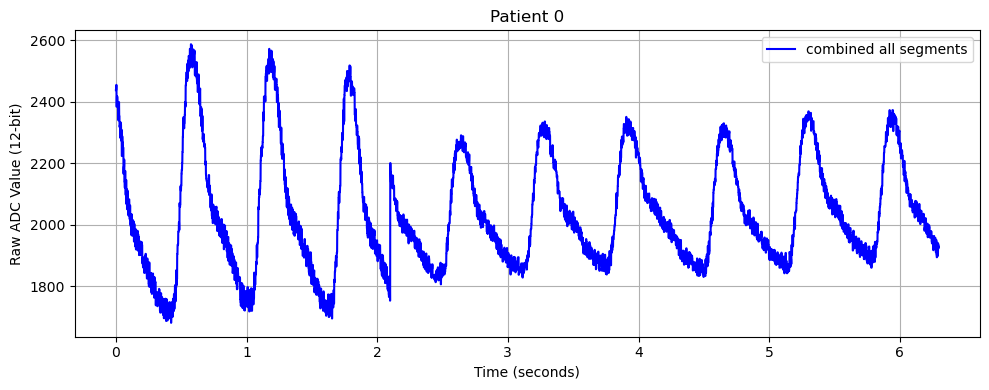

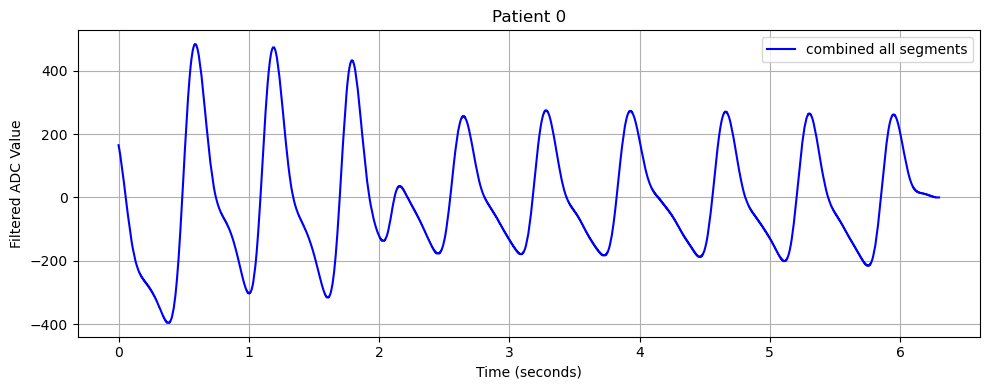

In [25]:
plot_combined_ppg_signal(ppg_data_with_noise,0,False)
plot_combined_ppg_signal(ppg_data,0,True)

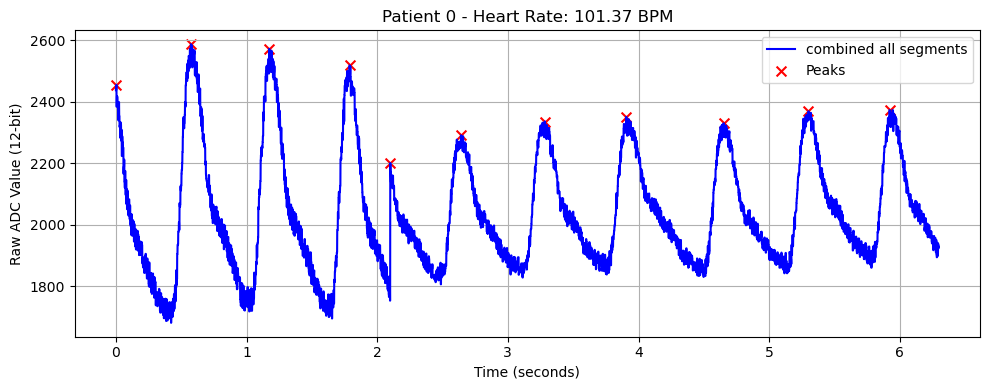

Patient 0- Heart Rate: 101.37 BPM


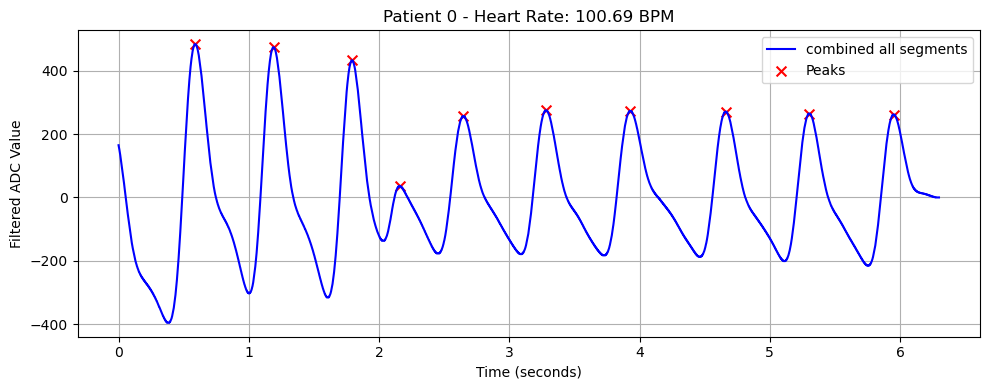

Patient 0- Heart Rate: 100.69 BPM


In [26]:
plot_combined_ppg_signal_with_peaks(ppg_data_with_noise,0,False)
plot_combined_ppg_signal_with_peaks(ppg_data,0,True)

In [112]:
def calculate_heart_rate(ppg_signal_data_array, patient_idx, sampling_rate=1000):
    # Check array bounds
    num_patients, num_samples = ppg_signal_data_array.shape
    # Extract the signal for the specified patient
    signal = ppg_signal_data_array[patient_idx, :]
    # Detect peaks (value > mean, min distance 0.3s = 300 samples at 1000 Hz)
    peaks, _ = find_peaks(signal, height=np.mean(signal), distance=300)

    # Calculate heart rate
    if len(peaks) >= 2:
        peak_times = peaks / sampling_rate  # Convert sample indices to seconds
        inter_beat_intervals = np.diff(peak_times)  # Time between consecutive peaks in seconds
        average_interval = np.mean(inter_beat_intervals)  # Average IBI in seconds
        heart_rate = 60 / average_interval  # Convert to beats per minute (BPM)
        return heart_rate
    else:
        return "Insufficient peaks to calculate heart rate"

In [113]:
def calulate_heart_rates(ppg_signal_data_array):
    num_patients,num_samples=ppg_signal_data_array.shape
    heart_rate=np.zeros(num_patients)
    for i in range(num_patients):
        heart_rate[i]=calculate_heart_rate(ppg_signal_data_array,i)
    return heart_rate
        

In [114]:
calulate_heart_rates(ppg_data)

array([100.68991236,  84.8956491 ,  86.47313156,  94.70361277,
        88.59357697,  84.53680874,  93.37713989,  88.138083  ,
        57.60368664,  79.00677201,  93.75      ,  92.69988413,
        84.01680336,  79.57559682,  88.47926267,  84.95575221,
        97.64918626,  86.90928843,  85.7449089 ,  85.65310493,
        87.62779053, 107.52688172,  87.99266728,  84.92569002,
        75.20143241,  66.15214994,  84.46243181,  92.65614276,
        94.970102  ,  72.91666667,  71.77033493,  87.17762441,
        73.90679532,  77.70582794,  63.60424028,  83.58208955,
        98.70224822,  72.90400972,  91.75870858,  74.62686567,
        72.80291212, 114.52368558, 105.63380282,  83.20332813,
        88.85597927,  58.45674201,  92.44992296,  73.60672976,
        94.77009477,  76.21121394,  88.23529412,  70.02528691,
       106.7425725 ,  74.12636781,  80.12209081,  85.45486915,
        94.09304757,  77.90762382,  70.83825266,  90.49773756,
        77.31958763,  69.16426513,  86.047941  ,  56.74

In [125]:
df.columns

Index(['Num.', 'subject_ID', 'Sex(M/F)', 'Age(year)', 'Height(cm)',
       'Weight(kg)', 'Systolic Blood Pressure(mmHg)',
       'Diastolic Blood Pressure(mmHg)', 'Heart Rate(b/m)', 'BMI(kg/m^2)',
       'Hypertension', 'Diabetes', 'cerebral infarction',
       'cerebrovascular disease'],
      dtype='object', name=0)

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Num.                            219 non-null    object
 1   subject_ID                      219 non-null    object
 2   Sex(M/F)                        219 non-null    object
 3   Age(year)                       219 non-null    object
 4   Height(cm)                      219 non-null    object
 5   Weight(kg)                      219 non-null    object
 6   Systolic Blood Pressure(mmHg)   219 non-null    object
 7   Diastolic Blood Pressure(mmHg)  219 non-null    object
 8   Heart Rate(b/m)                 219 non-null    object
 9   BMI(kg/m^2)                     219 non-null    object
 10  Hypertension                    219 non-null    object
 11  Diabetes                        38 non-null     object
 12  cerebral infarction             20 non-null     ob

In [127]:
df.head()

,Num.,subject_ID,Sex(M/F),Age(year),Height(cm),Weight(kg),Systolic Blood Pressure(mmHg),Diastolic Blood Pressure(mmHg),Heart Rate(b/m),BMI(kg/m^2),Hypertension,Diabetes,cerebral infarction,cerebrovascular disease
0,1,2,Female,45,152,63,161,89,97,27.268006,Stage 2 hypertension,NaN,NaN,NaN
1,2,3,Female,50,157,50,160,93,76,20.284799,Stage 2 hypertension,NaN,NaN,NaN
2,3,6,Female,47,150,47,101,71,79,20.888889,Normal,NaN,NaN,NaN
3,4,8,Male,45,172,65,136,93,87,21.971336,Prehypertension,NaN,NaN,NaN
4,5,9,Female,46,155,65,123,73,73,27.055151,Prehypertension,NaN,NaN,NaN


In [118]:
from sklearn.preprocessing import MinMaxScaler
def normalize_signal_per_array(signal_array):
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_arrays = [scaler.fit_transform(sub_array.reshape(-1, 1)).flatten() for sub_array in signal_array]
    return np.array(normalized_arrays, dtype=object)

In [119]:
normalized_ppg_data=normalize_signal_per_array(ppg_data)

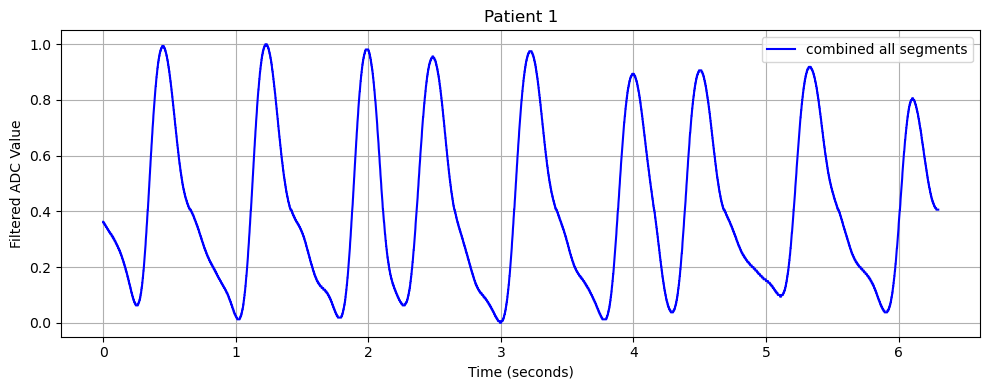

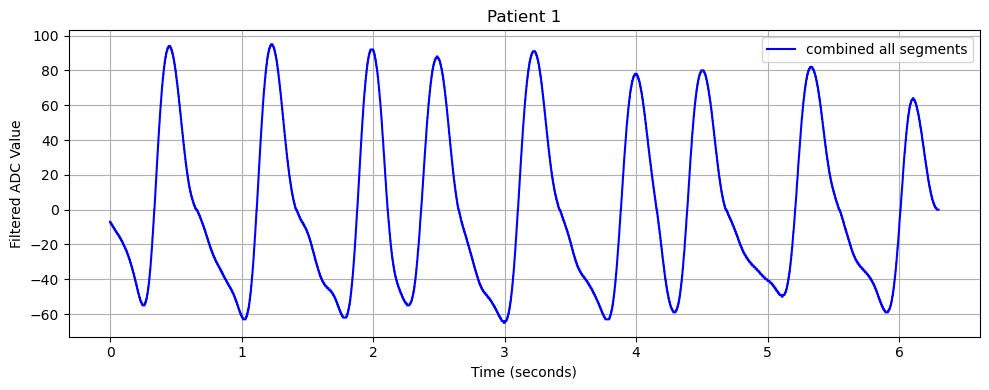

In [120]:
plot_combined_ppg_signal(normalized_ppg_data,1,True)
plot_combined_ppg_signal(ppg_data,1,True)

In [128]:
def add_bgl_ecg_columns(df):
    total_rows = len(df)  # Get total rows (e.g., 219)

    # =================== BGL LEVEL (Blood Glucose) ===================
    num_normal_bgl = int(total_rows * 0.80)  # 80% Normal
    num_hypo_bgl = int(total_rows * 0.10)    # 10% Hypoglycemia
    num_hyper_bgl = total_rows - (num_normal_bgl + num_hypo_bgl)  # 10% Hyperglycemia

    # Generate BGL values
    normal_bgl = np.random.uniform(80, 140, num_normal_bgl)
    hypo_bgl = np.random.uniform(50, 69, num_hypo_bgl)
    hyper_bgl = np.random.uniform(181, 250, num_hyper_bgl)

    # Combine & shuffle BGL values
    bgl_values = np.concatenate([normal_bgl, hypo_bgl, hyper_bgl])
    np.random.shuffle(bgl_values)

    # =================== ECG LEVEL (Heart Rate Condition) ===================
    num_normal_ecg = int(total_rows * 0.80)  # 80% Normal
    num_bradycardia = int(total_rows * 0.10)  # 10% Bradycardia (Slow HR)
    num_tachycardia = total_rows - (num_normal_ecg + num_bradycardia)  # 10% Tachycardia (Fast HR)

    # Generate ECG values (Heart Rate in beats per minute)
    normal_ecg = np.random.uniform(60, 100, num_normal_ecg)  # Normal HR (60-100 bpm)
    bradycardia_ecg = np.random.uniform(30, 59, num_bradycardia)  # Bradycardia (<60 bpm)
    tachycardia_ecg = np.random.uniform(101, 180, num_tachycardia)  # Tachycardia (>100 bpm)

    # Combine & shuffle ECG values
    ecg_values = np.concatenate([normal_ecg, bradycardia_ecg, tachycardia_ecg])
    np.random.shuffle(ecg_values)

    # =================== Add to DataFrame ===================
    df["BGL Level"] = bgl_values
    df["ECG Level"] = ecg_values

    return df

In [129]:
df=add_bgl_ecg_columns(df)
df.head()

,Num.,subject_ID,Sex(M/F),Age(year),Height(cm),Weight(kg),Systolic Blood Pressure(mmHg),Diastolic Blood Pressure(mmHg),Heart Rate(b/m),BMI(kg/m^2),Hypertension,Diabetes,cerebral infarction,cerebrovascular disease,BGL Level,ECG Level
0,1,2,Female,45,152,63,161,89,97,27.268006,Stage 2 hypertension,NaN,NaN,NaN,56.859550,88.765868
1,2,3,Female,50,157,50,160,93,76,20.284799,Stage 2 hypertension,NaN,NaN,NaN,129.434692,48.573841
2,3,6,Female,47,150,47,101,71,79,20.888889,Normal,NaN,NaN,NaN,116.822633,82.923029
3,4,8,Male,45,172,65,136,93,87,21.971336,Prehypertension,NaN,NaN,NaN,101.492669,93.883911
4,5,9,Female,46,155,65,123,73,73,27.055151,Prehypertension,NaN,NaN,NaN,88.915657,66.255639


In [36]:
# sex // apply one hot or label idk which
#noomralize the age,height,weight,heartrate

In [130]:
def preprocess_health_data(df):
    selected_columns = [2,3,4,5,8,10,15,6,7,14]  # Column indices
    df_selected = df.iloc[:, selected_columns].copy()  # Select columns correctly
    # Label Encoding for Sex (Male = 1, Female = 0)
    df_selected["Sex(M/F)"] = LabelEncoder().fit_transform(df_selected["Sex(M/F)"])
    df_selected["Hypertension"] = LabelEncoder().fit_transform(df_selected["Hypertension"])

    # Convert numerical columns to numeric type and nomralize them
    numeric_cols = [
        "Age(year)", 
        "Height(cm)", 
        "Weight(kg)", 
        "Heart Rate(b/m)", 
        "Systolic Blood Pressure(mmHg)", 
        "Diastolic Blood Pressure(mmHg)",
        "BGL Level",
        "ECG Level",
    ]
    df_selected[numeric_cols] = df_selected[numeric_cols].apply(pd.to_numeric, errors='coerce')
    scaler = MinMaxScaler()
    df_selected[numeric_cols] = scaler.fit_transform(df_selected[numeric_cols])
    return df_selected,scaler

In [131]:
df_req,scaler_for_df=preprocess_health_data(df)

In [132]:
df_req

,Sex(M/F),Age(year),Height(cm),Weight(kg),Heart Rate(b/m),Hypertension,ECG Level,Systolic Blood Pressure(mmHg),Diastolic Blood Pressure(mmHg),BGL Level
0,0,0.369231,0.137255,0.402985,0.833333,3,0.412252,0.794118,0.723077,0.035226
1,0,0.446154,0.235294,0.208955,0.444444,3,0.124870,0.784314,0.784615,0.408521
2,0,0.400000,0.098039,0.164179,0.500000,0,0.370474,0.205882,0.446154,0.343650
3,1,0.369231,0.529412,0.432836,0.648148,1,0.448847,0.549020,0.784615,0.264799
4,0,0.384615,0.196078,0.432836,0.388889,1,0.251299,0.421569,0.476923,0.200109
...,...,...,...,...,...,...,...,...,...,...
214,1,0.046154,0.686275,0.507463,0.462963,0,0.390304,0.303922,0.430769,0.345897
215,0,0.061538,0.215686,0.164179,0.500000,0,0.332207,0.127451,0.230769,0.397270
216,1,0.061538,0.607843,0.283582,0.370370,1,1.000000,0.392157,0.415385,0.203598
217,1,0.061538,0.549020,0.402985,0.277778,0,0.446766,0.254902,0.415385,0.396267


In [133]:
from sklearn.model_selection import train_test_split

In [134]:
import numpy as np
from sklearn.model_selection import train_test_split

def prepare_data(ppg_data, df_static, df_targets, test_size=0.3, val_size=0.5, random_state=42):
    # Convert to NumPy arrays and ensure float32
    X_ppg = np.array(ppg_data, dtype=np.float32)
    X_static = df_static.to_numpy().astype(np.float32)
    y = df_targets.to_numpy().astype(np.float32)

    # Handle NaNs (replace with 0)
    X_ppg = np.nan_to_num(X_ppg, nan=0.0)
    X_static = np.nan_to_num(X_static, nan=0.0)
    y = np.nan_to_num(y, nan=0.0)

    # Validate and fix PPG shape (ensure 3D: [samples, timesteps, 1])
    if len(X_ppg.shape) == 2:  # If 2D (e.g., [219, 6300])
        X_ppg = X_ppg[..., np.newaxis]  # Add channel dimension: [219, 6300, 1]
    elif len(X_ppg.shape) != 3 or X_ppg.shape[2] != 1:
        raise ValueError(f"PPG data must be 3D with shape (samples, timesteps, 1), got {X_ppg.shape}")

    # Validate static and target shapes
    if len(X_static.shape) != 2 or X_static.shape[1] != df_static.shape[1]:
        raise ValueError(f"Static data must be 2D with {df_static.shape[1]} features, got {X_static.shape}")
    if len(y.shape) != 2 or y.shape[1] != df_targets.shape[1]:
        raise ValueError(f"Target data must be 2D with {df_targets.shape[1]} targets, got {y.shape}")

    # Ensure consistent number of samples
    n_samples = X_ppg.shape[0]
    if X_static.shape[0] != n_samples or y.shape[0] != n_samples:
        raise ValueError(f"All inputs must have same number of samples ({n_samples}), got PPG={X_ppg.shape[0]}, Static={X_static.shape[0]}, BP={y.shape[0]}")

    # First split: Train vs Temp (val + test)
    X_ppg_train, X_ppg_temp, X_static_train, X_static_temp, y_train, y_temp = train_test_split(
        X_ppg, X_static, y,
        test_size=test_size,
        random_state=random_state
    )

    # Second split: Temp into Val and Test
    X_ppg_val, X_ppg_test, X_static_val, X_static_test, y_val, y_test = train_test_split(
        X_ppg_temp, X_static_temp, y_temp,
        test_size=val_size,
        random_state=random_state
    )

    # Enhanced debugging output
    print("Data Preparation Details:")
    print(f"Input PPG: shape={X_ppg.shape}, dtype={X_ppg.dtype}, sample={X_ppg[0, :5, 0]}")
    print(f"Input Static: shape={X_static.shape}, dtype={X_static.dtype}, sample={X_static[0]}")
    print(f"Input BP: shape={y.shape}, dtype={y.dtype}, sample={y[0]}")
    print("\nSplit Shapes:")
    print(f"Train: PPG={X_ppg_train.shape}, Static={X_static_train.shape}, BP={y_train.shape}")
    print(f"Val: PPG={X_ppg_val.shape}, Static={X_static_val.shape}, BP={y_val.shape}")
    print(f"Test: PPG={X_ppg_test.shape}, Static={X_static_test.shape}, BP={y_test.shape}")

    return (X_ppg_train, X_static_train, y_train,
            X_ppg_val, X_static_val, y_val,
            X_ppg_test, X_static_test, y_test)



In [135]:
# Usage
X_ppg_train, X_static_train, y_train, \
X_ppg_val, X_static_val, y_val, \
X_ppg_test, X_static_test, y_test = prepare_data(
    ppg_data=normalized_ppg_data,
    df_static=df_req.iloc[:, :9],  # e.g., sex, age, height, weight, heart_rate ,SBP, DBP
    df_targets=df_req.iloc[:, 9:]  # e.g.,BGL
)

Data Preparation Details:
Input PPG: shape=(219, 6300, 1), dtype=float32, sample=[0.6375     0.63522726 0.63295454 0.6306818  0.6272727 ]
Input Static: shape=(219, 9), dtype=float32, sample=[0.         0.36923078 0.13725491 0.40298507 0.8333333  3.
 0.4122518  0.7941176  0.72307694]
Input BP: shape=(219, 1), dtype=float32, sample=[0.03522612]

Split Shapes:
Train: PPG=(153, 6300, 1), Static=(153, 9), BP=(153, 1)
Val: PPG=(33, 6300, 1), Static=(33, 9), BP=(33, 1)
Test: PPG=(33, 6300, 1), Static=(33, 9), BP=(33, 1)


In [136]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input, regularizers

def build_lstm_model(timesteps=6300, static_features=9):
    """
    Build an LSTM-based hybrid model for blood pressure prediction.
    
    Parameters:
    - timesteps: Number of PPG timesteps (default: 6300)
    - static_features: Number of static features (default: 9)
    
    Returns:
    - Compiled Keras model
    """
    # Define inputs
    ppg_input = Input(shape=(timesteps, 1), name='ppg_input')  # PPG time-series: (samples, 6300, 1)
    static_input = Input(shape=(static_features,), name='static_input')  # Static features: (samples, 5)

    # LSTM branch for PPG
    x = layers.LSTM(64, return_sequences=False)(ppg_input)  # 64 units, outputs (samples, 64)
    x = layers.BatchNormalization()(x)  # Normalize LSTM outputs for stability
    ppg_features = layers.Dense(128, activation='relu', 
                               kernel_regularizer=regularizers.l2(0.01))(x)  # 128 units, L2 penalty

    # Combine PPG features with static features
    combined = layers.concatenate([ppg_features, static_input])  # (samples, 128 + 9 = 137)

    # Dense layers for prediction
    x = layers.Dense(64, activation='relu', 
                    kernel_regularizer=regularizers.l2(0.01))(combined)  # 64 units, L2 penalty
    x = layers.BatchNormalization()(x)  # Normalize for stability
    x = layers.Dropout(0.2)(x)  # 20% dropout to prevent overfitting
    output = layers.Dense(1, activation='linear', name='bp_output')(x)  # 1 output:

    # Define and compile model
    model = Model(inputs=[ppg_input, static_input], outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Print model summary
    print("Model Summary:")
    model.summary()

    return model

# Example usage
# model = build_lstm_model(timesteps=6300, static_features=5)

In [143]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

def train_model(model, X_ppg_train, X_static_train, y_train, X_ppg_val, X_static_val, y_val,
                epochs=50, batch_size=16):
    # Define early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',    # Monitor validation loss
        patience=10,           # Stop if no improvement for 10 epochs
        restore_best_weights=True  # Revert to best weights
    )

    # Train the model
    history = model.fit(
        {'ppg_input': X_ppg_train, 'static_input': X_static_train},  # Dictionary of named inputs
        y_train,
        validation_data=({'ppg_input': X_ppg_val, 'static_input': X_static_val}, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1  # Show progress per epoch
    )

    # Plot training history
    plt.figure(figsize=(12, 4))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()

    # MAE plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('Training and Validation MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, history

In [144]:
model = build_lstm_model(timesteps=6300, static_features=9)

Model Summary:


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ ppg_input (InputLayer)        │ (None, 6300, 1)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_6 (LSTM)                 │ (None, 64)                │          16,896 │ ppg_input[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_12        │ (None, 64)                │             256 │ lstm_6[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_12 (Dense)              │ (None, 128)               │           8,320 │ batch_normalization_12[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ static_input (InputLayer)     │ (None, 9)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_6 (Concatenate)   │ (None, 137)               │               0 │ dense_12[0][0],            │
│                               │                           │                 │ static_input[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_13 (Dense)              │ (None, 64)                │           8,832 │ concatenate_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_13        │ (None, 64)                │             256 │ dense_13[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_6 (Dropout)           │ (None, 64)                │               0 │ batch_normalization_13[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bp_output (Dense)             │ (None, 1)                 │              65 │ dropout_6[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 34,625 (135.25 KB)

 Trainable params: 34,369 (134.25 KB)

 Non-trainable params: 256 (1.00 KB)

In [145]:
import numpy as np

print("X_ppg_train shape:", X_ppg_train.shape)  # Should be (samples, 6300, 1)
print("X_static_train shape:", X_static_train.shape)  # Should be (samples, 9)
print("y_train shape:", y_train.shape)  # Should be (samples, 1)
print("X_ppg_val shape:", X_ppg_val.shape)  # Should be (samples, 6300, 1)
print("X_static_val shape:", X_static_val.shape)  # Should be (samples, 9)
print("y_val shape:", y_val.shape)  # Should be (samples, 1)


X_ppg_train shape: (153, 6300, 1)
X_static_train shape: (153, 9)
y_train shape: (153, 1)
X_ppg_val shape: (33, 6300, 1)
X_static_val shape: (33, 9)
y_val shape: (33, 1)


In [147]:
history = model.fit(
    {"ppg_input": X_ppg_train, "static_input": X_static_train},  # Correct dictionary format
    y_train,
    validation_data=({"ppg_input": X_ppg_val, "static_input": X_static_val}, y_val),  # Correct validation data format
    epochs=50,
    batch_size=16
)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 2.3845 - mae: 0.6468 - val_loss: 1.7451 - val_mae: 0.2510
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 2.1569 - mae: 0.5260 - val_loss: 1.6655 - val_mae: 0.1648
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - loss: 2.0034 - mae: 0.5200 - val_loss: 1.6149 - val_mae: 0.1445
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 1.9955 - mae: 0.5123 - val_loss: 1.5762 - val_mae: 0.1467
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - loss: 2.0782 - mae: 0.5625 - val_loss: 1.5421 - val_mae: 0.1483
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 1.9769 - mae: 0.5360 - val_loss: 1.5096 - val_mae: 0.1446
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - loss: 1.7863 - mae: 0.4413 - val_loss: 1.4752 - val_mae: 0.1472
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - loss: 1.9048 - mae: 0.5270 - val_loss: 1.4438 - val_mae: 0.1571
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - loss: 1.8247 - mae: 

In [81]:
model.save("lstm_bp_model.h5")  # Saves as HDF5 file

In [148]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ ppg_input (InputLayer)        │ (None, 6300, 1)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_6 (LSTM)                 │ (None, 64)                │          16,896 │ ppg_input[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_12        │ (None, 64)                │             256 │ lstm_6[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_12 (Dense)              │ (None, 128)               │           8,320 │ batch_normalization_12[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ static_input (InputLayer)     │ (None, 9)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_6 (Concatenate)   │ (None, 137)               │               0 │ dense_12[0][0],            │
│                               │                           │                 │ static_input[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_13 (Dense)              │ (None, 64)                │           8,832 │ concatenate_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_13        │ (None, 64)                │             256 │ dense_13[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_6 (Dropout)           │ (None, 64)                │               0 │ batch_normalization_13[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bp_output (Dense)             │ (None, 1)                 │              65 │ dropout_6[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 103,365 (403.77 KB)

 Trainable params: 34,369 (134.25 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 68,740 (268.52 KB)

In [171]:
def normalize_single_signal(signal):
    signal=np.array(signal)
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_signal = scaler.fit_transform(signal.reshape(-1, 1)).flatten()
    return normalized_signal


In [153]:
# Get min, max, and scale values
print("Feature Min Values:", scaler_for_df.data_min_)
print("Feature Max Values:", scaler_for_df.data_max_)
print("Feature Scale Factors:", scaler_for_df.scale_)
print("Feature Offsets:", scaler_for_df.min_)  # Used internally for scaling


Feature Min Values: [ 21.         145.          36.          52.          80.
  42.          50.01096599  31.11004591]
Feature Max Values: [ 86.         196.         103.         106.         182.
 107.         244.42874032 170.96588475]
Feature Scale Factors: [0.01538462 0.01960784 0.01492537 0.01851852 0.00980392 0.01538462
 0.00514356 0.00715022]
Feature Offsets: [-0.32307692 -2.84313725 -0.53731343 -0.96296296 -0.78431373 -0.64615385
 -0.25723454 -0.22244367]


In [180]:
def normalize_value(value, index, scaler):
    """Scales a single value using a pre-fitted MinMaxScaler."""
    return (value - scaler.data_min_[index]) * scaler.scale_[index]

In [210]:
def normalize_static(static,scaler):
    static = np.array(static, dtype=np.float32)  # Ensure NumPy array
    scaled_static = static
    index_list=[[1,0],[2,1],[3,2],[4,3],[6,4],[7,5],[8,6]]
    for i,j in index_list:
        scaled_static[i]=normalize_value(static[i],j,scaler)
    return scaled_static

In [211]:
normalize_single_signal(ppg_data[0])[6299]

0.44999999999999996

In [212]:
normalized_ppg_data[0][6299]

0.44999999999999996

In [236]:
def predict_bgl(signal, static, model, scaler_for_df):
    normalized_signal = normalize_single_signal(signal)  # Normalize PPG signal
    normalized_static = normalize_static(static, scaler_for_df)
    normalized_signal = signal.reshape(1, 6300, 1)  # Shape (1, 6300, 1)
    normalized_static = static.reshape(1, -1)  # Shape (1, num_static_features)
    predicted_bgl = model.predict({"ppg_input": normalized_signal, "static_input": normalized_static})
    return predicted_bgl[0][0] 


In [238]:
print(predict_bgl(X_ppg_train[0],X_static_train[0],model,scaler_for_df))
print(y_val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
0.5140327
[0.1917]


In [204]:
scaler_for_df.data_max_.shape

(8,)

In [243]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Predict on test set
y_pred = model.predict({"ppg_input": X_ppg_test, "static_input": X_static_test})
# Compute metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R² Score
for i in range(y_test.size):
    print(i,y_test[i],y_pred[i])
# Print results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step
0 [0.15597202] [0.4413448]
1 [0.28513178] [0.40964374]
2 [0.3973067] [0.59718496]
3 [0.4230558] [0.4035743]
4 [0.37565535] [0.39182305]
5 [0.334657] [0.57810926]
6 [0.04841661] [0.55011237]
7 [0.45212075] [0.55265725]
8 [0.44393235] [0.61767966]
9 [0.34626135] [0.50347626]
10 [0.38175657] [0.5804067]
11 [0.2905726] [0.5009359]
12 [0.08823036] [0.52042764]
13 [0.3288136] [0.36532807]
14 [0.1886792] [0.43709916]
15 [0.27078998] [0.5343541]
16 [0.3962674] [0.32538307]
17 [0.2811834] [0.39458802]
18 [0.36239684] [0.44191548]
19 [0.34097245] [0.40195984]
20 [0.34546962] [0.45223433]
21 [0.2670726] [0.43408644]
22 [0.20293666] [0.5960347]
23 [0.0826071] [0.49458188]
24 [0.26986217] [0.4156874]
25 [0.31692764] [0.44381195]
26 [0.27019456] [0.45171985]
27 [0.1994752] [0.44154423]
28 [0.00960518] [0.42709392]
29 [0.43790913] [0.3977991]
30 [0.21606465] [0.45926622]
31 [0.23551995] [0.43894282]
32 [0.17534031] [0.43150637]
MAE: 0.1961
MSE: 0.0539
RMSE: 0.23

In [244]:
df.head()

,Num.,subject_ID,Sex(M/F),Age(year),Height(cm),Weight(kg),Systolic Blood Pressure(mmHg),Diastolic Blood Pressure(mmHg),Heart Rate(b/m),BMI(kg/m^2),Hypertension,Diabetes,cerebral infarction,cerebrovascular disease,BGL Level,ECG Level
0,1,2,Female,45,152,63,161,89,97,27.268006,Stage 2 hypertension,NaN,NaN,NaN,56.859550,88.765868
1,2,3,Female,50,157,50,160,93,76,20.284799,Stage 2 hypertension,NaN,NaN,NaN,129.434692,48.573841
2,3,6,Female,47,150,47,101,71,79,20.888889,Normal,NaN,NaN,NaN,116.822633,82.923029
3,4,8,Male,45,172,65,136,93,87,21.971336,Prehypertension,NaN,NaN,NaN,101.492669,93.883911
4,5,9,Female,46,155,65,123,73,73,27.055151,Prehypertension,NaN,NaN,NaN,88.915657,66.255639


In [13]:
df=get_df()

In [14]:
ppg_signal_with_noise_segs=load_ppg_signals()

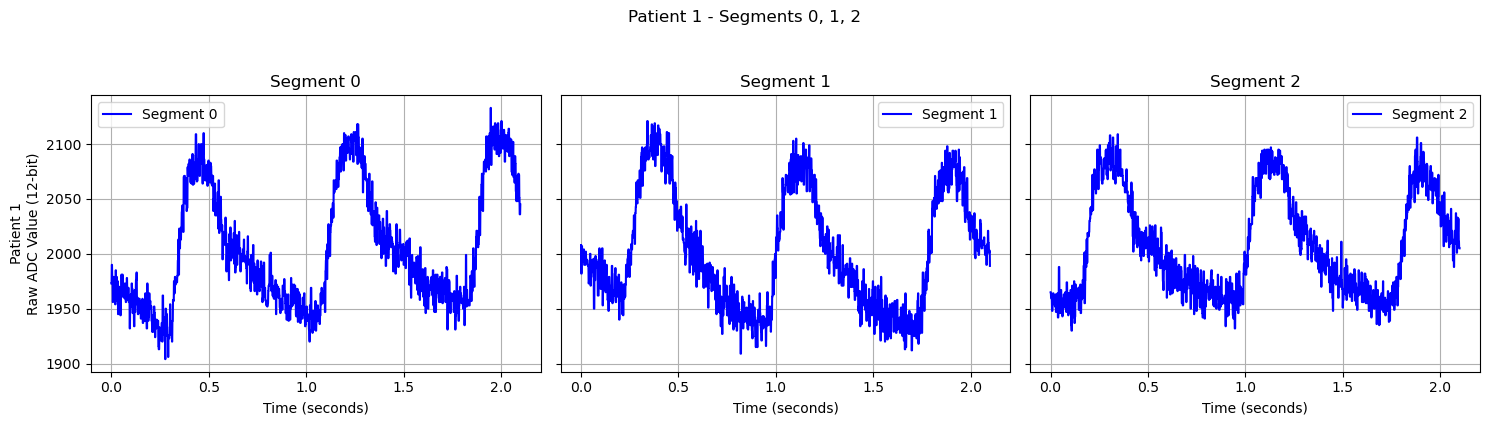

In [31]:
plot_ppg_signal_all_segments(ppg_signal_with_noise_segs,1,False,"ppg_signal_with_noise_segs")

In [29]:
ppg_signal_segs=remove_noise_from_ppg(ppg_signal_with_noise_segs)

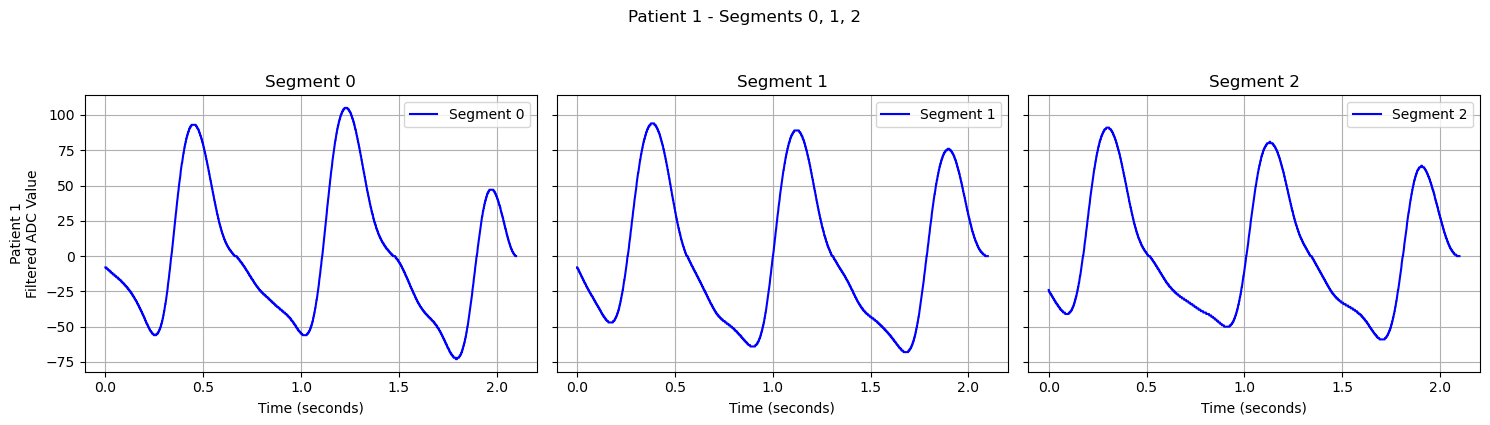

In [32]:
plot_ppg_signal_all_segments(ppg_signal_segs,1,True,"ppg_signal_segs")

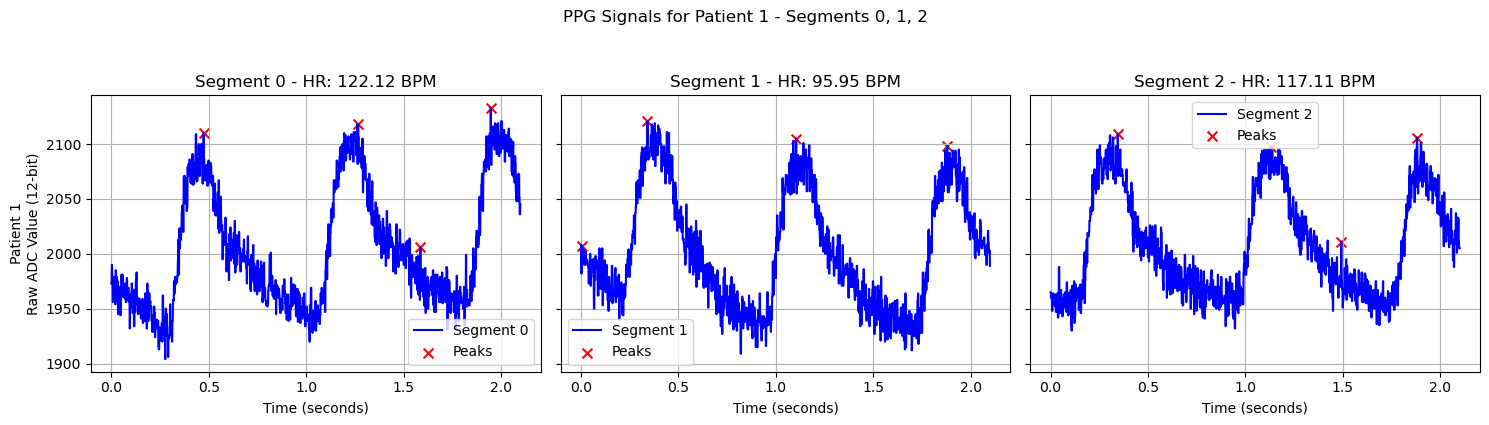

Patient 1 - Segment 0: 122.12 BPM, Segment 1: 95.95 BPM, Segment 2: 117.11 BPM


In [33]:
plot_ppg_signal_with_peaks_all_segments(ppg_signal_with_noise_segs,1,False,"ppg_signal_with_noise_segs_peaks")

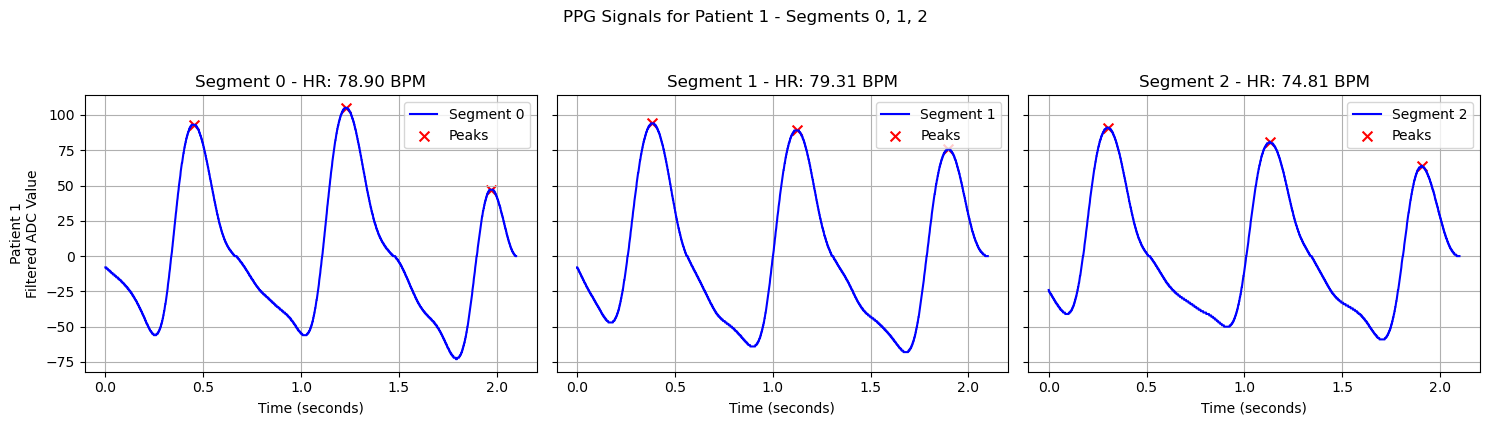

Patient 1 - Segment 0: 78.90 BPM, Segment 1: 79.31 BPM, Segment 2: 74.81 BPM


In [34]:
plot_ppg_signal_with_peaks_all_segments(ppg_signal_segs,1,True,"ppg_signal_segs_peaks")